In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import os
import sys

sys.path.append(os.getcwd()[:-10])
from kalman_filter import *
from utils.performance_metrics import *

### In this notebook we will build a pairs trading strategy

The idea is to find a pair of securities whose price series cointegrate. By definition, cointegrating price series allows us to build a linear combination of the pair which is stationary. From there we can build a mean reverting strategy on the stationary series.

These pairs are often created from clustering algorithms, which aim to group securities which are "similar" together. As an example, the clustering projects groups stocks 'MSFT' and 'V' together, so let's investigate.

We will split our data into a training set (2010/01/01 - 2017/01/01) and a test set (2017/01/01 - 2020/01/01). Parameters are optimised on the training set and test set will be used to evaluate overall performance.

In [2]:
security_1 = 'MSFT'
security_2 = 'V'
tickers = [security_1, security_2]

price_data = yf.download(tickers=tickers,
                         start='2010-01-01',
                         end='2017-01-01')['Adj Close']
price_data = price_data[tickers]

[*********************100%***********************]  2 of 2 completed


###  Visual analysis of data

securities appear somewhat cointegrating; it might be promising to try trading this spread.

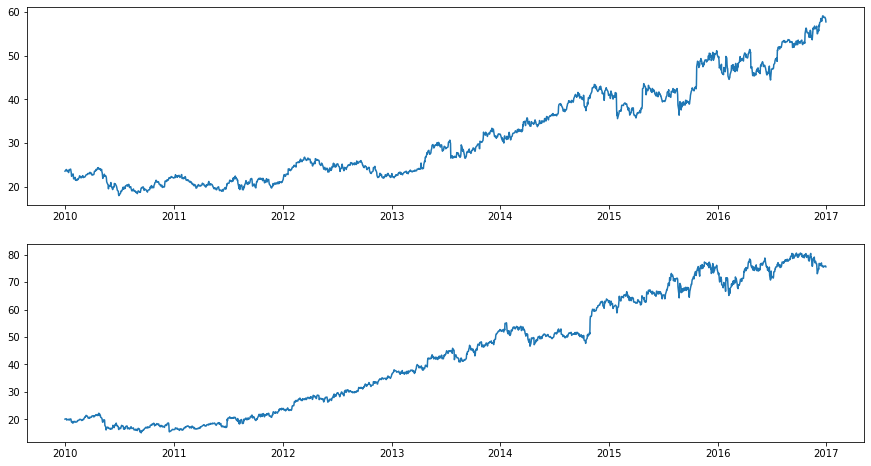

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set(figheight=8,figwidth=15)

ax[0].plot(price_data.loc[:, security_1])
ax[1].plot(price_data.loc[:, security_2])

### The next step is to figure out how to create this linear combination

The most common methods are the Cointegrated Augmented Dickey-Fuller Test (CADF) and Johansen tests, which provide both a hedge ratio between the two securities, and test statistics for stationarity. Since hedge ratios are seldom constant over many years, these tests are typically applied on a rolling window (hyperparameter), allowing dynamic hedge ratio updating.

Unfortunately, with daily bar data, the changing hedge ratios can be highly unstable, and such methods are better for data with finer resolution (preferable events based).

Therefore, we will use Kalman filter algorithm instead. Kalman filter assumes a linear relation between the prices of both securities.

(let x, y be price of securities 1, 2 respectively):

\begin{equation}
y = \beta x + \epsilon
\end{equation}

where $\epsilon$ is normally distributed with mean 0. The algorithm uses a Bayesian approach to updating $\beta$, based on its current guess $\hat\beta$ and observing the prediction error: $y - \hat{\beta}x$. The hyperparameters to provide are learning rates (how fast we update $\beta$), and the error covariance structure. The full explanation can be found in Ernest Chan's book.

References
- Ernest P. Chan. Algorithmic Trading.  John Wiley & Sons Inc.

In [4]:
beta, error, error_variance =\
    get_hedge_ratios_from_kalman_filter(price_data[security_1].values,
                                        price_data[security_2].values,
                                        learning_rate=1e-5,
                                        covariance=1e-4)

hedge_ratios = pd.DataFrame(np.stack([-np.round(beta[:, 0]), np.ones(error.size)], axis=1))

### Now we will trade using a bollinger bands strategy

The idea is to calculate zscores of the latest price, and enter positions when zscores exceed a threshold (e.g long when zscore < -1, short when zscore > 1).

How do we calculate these zscores? Looking at Kalman filter and recalling that linear regression estimates the conditional mean of the input variable, we see that the prediction error is simply $e = y - \bar{y}$, and therefore zscore will simply be $\cfrac{e}{\sqrt Q}$ where Q is the error_variance.

In [5]:
positions = get_bollinger_bands_positions(error=error,
                                          error_variance=error_variance,
                                          zscore_threshold=2)

### Calculating annual returns and sharpe ratios

Annual returns: 0.075
Sharpe ratio: 0.822


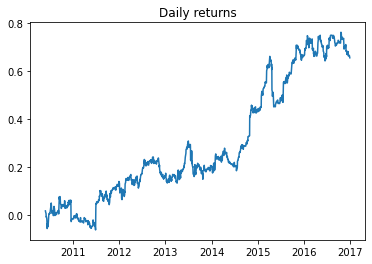

In [6]:
annual_returns, sharpe_ratio =\
    calculate_pnl_with_transaction_costs(price_data = price_data,
                                         positions = positions,
                                         portfolio_ratios = hedge_ratios,
                                         commissions_in_percent = 0.25,
                                         bid_ask_spread = 0.01)

print(f"Annual returns: {annual_returns}")
print(f"Sharpe ratio: {sharpe_ratio}")

### Conclusion

The annual returns and sharpe ratio aren't too impressive after accounting for transaction costs. This is expected since we are using a simple strategy with unoptimised hyperparameters.

In the next notebook we will tune hyperparameters via gridsearching and test out the strategy performance on out-of-sample data.